# Segmentation Model

In [1]:
# Prerequisites
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from segmentation_dataset import SegmentationDataset
import segmentation_models_pytorch as smp 



### Check Running Environment

In [2]:
# Check if notebook being run in Colab or locally  
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
print (f'Running in Colab: {IN_COLAB}')

# Check if GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using ", DEVICE)

Running in Colab: False
Using  cuda


### Set Hyperparameters

In [3]:
NR_EPOCHS = 50
BATCH_SIZE = 4

### Set 'train' and 'val' Datasets & Dataloaders

In [4]:
if IN_COLAB:
    pass
else:
    train_data_path = "data/processed/train"
    val_data_path = "data/processed/val"
    test_data_path = "data/processed/test"


train_dataset = SegmentationDataset(path_name=train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = SegmentationDataset(path_name=val_data_path)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Define Model

In [5]:
model = smp.FPN( #  Feature Pyramid Network
    encoder_name = "se_resnext50_32x4d", # Encoder - ResNeXt-50
    encoder_weights="imagenet", # Pretrained weights for encoder
    classes=6, # Number of output classes
    activation="sigmoid" #
) 

model.to(DEVICE)   # Move model to GPU if available

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Adam optimizer

criterion = nn.CrossEntropyLoss() # Cross-entropy loss
# criterion = smp.losses.DiceLoss(mode='multiclass') # Dice loss

### Training Loop

In [6]:
train_losses = []
val_losses = []

for epoch in range(NR_EPOCHS):

    # Training Phase
    model.train()
    running_train_loss = 0
    running_val_loss = 0

    for i, data in enumerate(train_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        output = model(image.float())

        # Calculate losses
        train_loss = criterion(output.float(), mask.long())

        # Back propagation
        train_loss.backward()
        optimizer.step()  # Update weights

        running_train_loss += train_loss.item()

    train_losses.append(running_train_loss)

    # Validation Phase
    model.eval()
    for i, data in enumerate(val_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # Forward Pass
        output = model(image.float())

        # Calculate losses
        val_loss = criterion(output.float(), mask.long())
        running_val_loss += val_loss.item()

    val_losses.append(running_val_loss)

    print(f"Epoch: {epoch}: Train Loss: {np.median(running_train_loss)}, Val Loss: {np.median(running_val_loss)}")


Epoch: 0: Train Loss: 217.26825296878815, Val Loss: 10.790672421455383
Epoch: 1: Train Loss: 193.72409641742706, Val Loss: 10.67814314365387
Epoch: 2: Train Loss: 188.44076323509216, Val Loss: 10.69177758693695
Epoch: 3: Train Loss: 185.15888381004333, Val Loss: 10.646353721618652
Epoch: 4: Train Loss: 183.3507809638977, Val Loss: 10.750880718231201
Epoch: 5: Train Loss: 183.34355223178864, Val Loss: 10.571726322174072
Epoch: 6: Train Loss: 182.01953530311584, Val Loss: 10.662376880645752
Epoch: 7: Train Loss: 180.81649160385132, Val Loss: 10.584443807601929
Epoch: 8: Train Loss: 179.80753076076508, Val Loss: 10.56519627571106
Epoch: 9: Train Loss: 178.85637021064758, Val Loss: 10.547440528869629
Epoch: 10: Train Loss: 178.4307541847229, Val Loss: 10.54577362537384
Epoch: 11: Train Loss: 177.89229547977448, Val Loss: 10.587934613227844
Epoch: 12: Train Loss: 177.938556432724, Val Loss: 10.621140360832214
Epoch: 13: Train Loss: 177.29051876068115, Val Loss: 10.649474382400513
Epoch: 14:

### Visualize

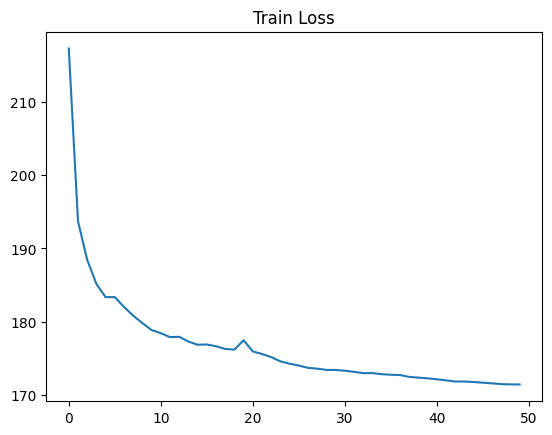

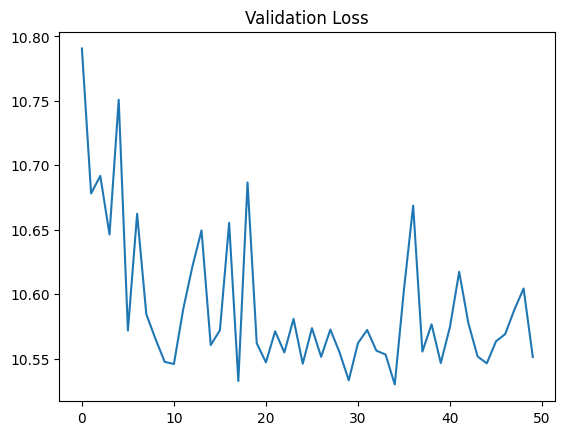

In [7]:
sns.lineplot(x = range(len(train_losses)), y= train_losses).set(title='Train Loss')
plt.show()
sns.lineplot(x = range(len(train_losses)), y= val_losses).set(title='Validation Loss')
plt.show()

### Save Model

In [8]:
torch.save(model.state_dict(), f'saved_models/FPN_epochs_{NR_EPOCHS}_crossentropy_state_dict.pth')